In [ ]:
import cv2
import numpy as np
import time
import matplotlib.pyplot as plt
%matplotlib inline
import rtde_control
import rtde_receive
import numpy
import math
rtde_r = rtde_receive.RTDEReceiveInterface("169.254.37.182")
rtde_c = rtde_control.RTDEControlInterface("169.254.37.182")


#Capturing position
rtde_c.moveL([-0.00772, -0.64201, 0.19098, 0.032, -3.154, -0.017], 0.5, 0.3)
time.sleep(1)


# Intrensic Matrix Obtained from Camera Calibration
n_mtx = [[5.23058487e+04,0.00000000e+00,4.61024155e+02],[0.00000000e+00,2.81347874e+04,2.39792318e+02],[0.00000000e+00,0.00000000e+00,1.00000000e+00]]
mtx = np.array(n_mtx)
# Distortion Matrix Obtained from Camera Calibration 
n_dist = [5.41119138e+01,-1.12643444e+04,3.13452550e-02,-3.04059948e-01,-4.39888679e+01]
dist = np.array(n_dist)


### CAPTURING FRAME BY USING DISPLAY FUNCTION
def display(img):
    fig=plt.figure(figsize=(12,10))
    ax=fig.add_subplot(111)
    ax.imshow(img)
# Define dictionary for marker detection
aruco_dict = cv2.aruco.Dictionary_get(cv2.aruco.DICT_4X4_100)
# Define parameters for marker detection
parameters = cv2.aruco.DetectorParameters_create()
# Create video capture object
cap = cv2.VideoCapture(0)
cap.set(cv2.CAP_PROP_FRAME_WIDTH, 848)
cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 480)
cap.set(5,30)
t1=time.time()
while True:
    # Read frame from camera
    ret, frame = cap.read()
    t2=time.time()
    if (t2-t1>=1):
        break
# Save frame as image file
cap.release()
cv2.imwrite('aruco.jpg',frame)

RuntimeError: Error: Could not connect to: 169.254.37.182 at 30004, verify the IP

In [ ]:
# Reading the captured Image
img = cv2.imread("C:/Users/Prajwal/Python Projects/Weimar SRA/TRIALS 1/Random Pose1/aruco.jpg")
# Convert frame to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

### DETECTING THE MARKERS IN THE FRAME
corners, ids, rejectedImgPoints = cv2.aruco.detectMarkers(gray, aruco_dict, parameters=parameters)
print(corners)
if ids is not None:
    # Estimate pose of each marker
    rvec, tvec, _ = cv2.aruco.estimatePoseSingleMarkers(corners, 0.05, mtx, dist)
    # Draw axes on the frame for each marker
    for i in range(ids.size):
        result_img = cv2.drawFrameAxes(img, mtx, dist, rvec[i, :, :], tvec[i, :, :], 0.03)
        # Store the pixel coordinates of the corners for each detected marker
    # Draw marker borders and IDs on the frame
    cv2.aruco.drawDetectedMarkers(img, corners, ids)
# Display the frame
display(img)

NameError: name 'aruco_dict' is not defined

In [3]:
print(corners)

NameError: name 'corners' is not defined

In [3]:
### FINDING THE CENTROID OF THE ARUCO/COMPONENT
idx = (corners[0][0][0][0]+corners[0][0][1][0]+corners[0][0][2][0]+corners[0][0][3][0])/4
idy = (corners[0][0][0][1]+corners[0][0][1][1]+corners[0][0][2][1]+corners[0][0][3][1])/4
id = idx,idy
print(id)
#print(id[0])

(384.75, 233.5)


In [4]:
### ROTATION MATRIX MULTIPLICATION 
# Inverse of Reference Rotation matrix
ref_mat_inv= [[5.37918941e-01,-8.73345818e-04,-8.42996115e-01],[-1.97692365e-02,-9.99737517e-01,-1.15790927e-02],[-8.42764730e-01,2.28940029e-02,-5.37795011e-01]]

# Rotation vector obtained from ArUco marker
rot_vec = np.array([rvec[0][0][0],rvec[0][0][1],rvec[0][0][2]])

# Obtain the rotation matrix from the rotation vector
rot_mat, _ = cv2.Rodrigues(rot_vec)
# Ref_rot_mat x Rot_mat_of_comp
result = np.dot(ref_mat_inv, rot_mat)
# Finding the angle of the ARuco wrt camera frame
angle=np.arcsin(result[1][0])
print('angle: ',angle)
print('angle in degrees:',math.degrees(angle))

angle:  0.7789572637070781
angle in degrees: 44.63096363147467


In [5]:
# ### ROTATING TCP AS PER THE ANGLE OBTAINED
# q=rtde_r.getActualQ()
# angle=angle + math.radians(90)
# q[5]-= angle
# rtde_c.moveJ(q, 0.5, 0.3)

True

In [5]:
### ROBOT TCP MOVES TO THE IDX,IDY OF COMPONENT
import pyrealsense2 as rs
import openpyxl
import time
from statistics import mode
import re

# Parameters
velocity = 0.5
acceleration = 0.5
dt = 1.0/500  # 2ms
lookahead_time = 0.1
gain = 300

result_f={}
depth_dict={}

rtde_c.moveL([-0.00772, -0.64201, 0.15098, 0.032, -3.154, -0.017], 0.5, 0.3)
time.sleep(1)
#Capturing position
rtde_c.moveL([-0.00772, -0.64201, 0.19098, 0.032, -3.154, -0.017], 0.5, 0.3)
time.sleep(1)

def depth_filter(win_data):
    x1,y1,x2,y2=win_data[0]-win_data[2]/2,win_data[1]-win_data[3]/2,win_data[0]+3*win_data[2]/2,win_data[1]+3*win_data[3]/2
    for i in range(int(y1),int(y2)):
        for j in range(int(x1),int(x2)):
            d=aligned_depth_frame.get_distance(int(j),int(i))
            if d!=0:
                k=[j,i]
                depth_dict[f'{k}']=round(d, 2)
    depth_list=depth_dict.values()
    filtered_depth=mode(depth_list)
    print(filtered_depth)
    corr_pix=list(depth_dict.keys())[list(depth_dict.values()).index(filtered_depth)] #get corresponding pixel of the distance value
    print(corr_pix)
    print(type(corr_pix))
    #print(corr_pix) #A string here
    corr_pix=re.split(', ',corr_pix)
    pix_corr=[]
    for num in corr_pix:
        num=re.sub(r"[\([{})\]]", "", num)
        num=int(num)
        pix_corr.append(num)
    
    print(pix_corr)
    print(type(pix_corr))
    a,b=pix_corr[0],pix_corr[1]
    depth=aligned_depth_frame.get_distance(int(a),int(b))
    return depth
def distance(x,y):
    #cv2.circle(capture,(x,y),2,(128,0,128),-1)
    #print((x,y))
    d=depth_frame.get_distance(int(x),int(y))
    print(d)
    if (d==0.0) :
        print('No depth info, Using an window')
        depth=depth_filter([int(x),int(y),10,10])
        x_w, y_w, z_w = convert_depth_to_phys_coord_using_realsense(int(x),int(y), depth, camera_info)
        print('Camera Points are:',x_w, y_w, z_w)
        p1=f'{x_w} {y_w} {z_w}'
        p = [float(value) for value in p1.split(' ')]
        p.append(1.0)
        dst_p=np.matmul(k,p)
        dst_p=dst_p.tolist()
        print(dst_p)
        rtde_c.moveL([dst_p[0]/1000.0, dst_p[1]/1000.0, dst_p[2]/1000.0, 0.032, -3.154, -0.017], 0.5, 0.3)
        #time.sleep(5)
        #dst_p=(dst_p[0])[:-1]
        #print(dst_p)
        del p1
        del p
    else:
        x_w, y_w, z_w = convert_depth_to_phys_coord_using_realsense(int(x),int(y), d, camera_info)
        print('Camera Points are:',x_w, y_w, z_w)
        p1=f'{x_w} {y_w} {z_w}'
        p = [float(value) for value in p1.split(' ')]
        p.append(1.0)
        dst_p=np.matmul(k,p)
        dst_p=dst_p.tolist()
        print(dst_p)
        rtde_c.moveL([dst_p[0]/1000.0, dst_p[1]/1000.0, dst_p[2]/1000.0, 0.032, -3.154, -0.017], 0.5, 0.3)
        #time.sleep(5)
        #dst_p=(dst_p[0])[:-1]
        #print(dst_p)
        del p1
        del p

def convert_depth_to_phys_coord_using_realsense(x, y, depth, cameraInfo):
    _intrinsics = rs.intrinsics()
    _intrinsics.width = cameraInfo.width
    _intrinsics.height = cameraInfo.height
    _intrinsics.ppx = cameraInfo.ppx
    _intrinsics.ppy = cameraInfo.ppy
    _intrinsics.fx = cameraInfo.fx
    _intrinsics.fy = cameraInfo.fy
    # _intrinsics.model = cameraInfo.distortion_model
    _intrinsics.model  = rs.distortion.none
    _intrinsics.coeffs = [i for i in cameraInfo.coeffs]
    result = rs.rs2_deproject_pixel_to_point(_intrinsics, [x, y], depth)
    # result[0]: right, result[1]: down, result[2]: forward
    return result[0], -result[1], -result[2]
"""
# Setup the pipeline
pipe = rs.pipeline()
cfg = rs.config()
cfg.enable_stream(rs.stream.depth, 1280, 720, rs.format.z16, 30)
cfg.enable_stream(rs.stream.color, 1280, 720, rs.format.bgr8, 30)
profile = pipe.start(cfg)
"""

#k= [[-9.99766881e+02,-4.32726613e+00,-3.49871451e+02,-2.08832869e+02],[1.48501389e+01,-1.00379407e+03,-2.10069591e+03,-1.31522522e+03],[-2.18229221e-01,-2.99400687e-01,-8.44418623e+01,4.61947710e+01],[0.00000000e+00,0.00000000e+00,0.00000000e+00,1.00000000e+00]]

k= [[-9.79365051e+02,6.22173726e-01,-1.81205747e+02,-1.09894855e+01],[2.63002626e+00,-9.88050938e+02,-2.41157019e+01,-6.93151121e+02],[1.52250424e+02,7.62100894e+01,-4.30734272e+02,4.48864321e+01],[0.00000000e+00,0.00000000e+00,0.00000000e+00,1.00000000e+00]]

# Create a pipeline
pipeline = rs.pipeline()

# Create a config and configure the pipeline to stream
config = rs.config()
pipeline_wrapper = rs.pipeline_wrapper(pipeline)
pipeline_profile = config.resolve(pipeline_wrapper)
device = pipeline_profile.get_device()
device_product_line = str(device.get_info(rs.camera_info.product_line))
print(device_product_line)
found_rgb = False
for s in device.sensors:
    if s.get_info(rs.camera_info.name) == 'RGB Camera':
        found_rgb = True
        print("There is a depth camera with color sensor")
        break
if not found_rgb:
    print("The demo requires Depth camera with Color sensor")
    exit(0)
config.enable_stream(rs.stream.depth, 848,480, rs.format.z16, 30)
config.enable_stream(rs.stream.color, 848,480, rs.format.bgr8, 30)
profile = pipeline.start(config)


# Setup the 'High Accuracy'-mode
depth_sensor = profile.get_device().first_depth_sensor()
depth_scale = depth_sensor.get_depth_scale()
print("Depth Scale is: " , depth_scale)
clipping_distance_in_meters = 1 #1 meter
clipping_distance = clipping_distance_in_meters / depth_scale
print(clipping_distance)
preset_range = depth_sensor.get_option_range(rs.option.visual_preset)
for i in range(int(preset_range.max)):
    visulpreset = depth_sensor.get_option_value_description(rs.option.visual_preset,i)
    print('%02d: %s'%(i,visulpreset))
    if visulpreset == "High Accuracy":
        depth_sensor.set_option(rs.option.visual_preset, i)
# enable higher laser-power for better detection
depth_sensor.set_option(rs.option.laser_power, 180)
# lower the depth unit for better accuracy and shorter distance covered
depth_sensor.set_option(rs.option.depth_units, 0.0005)
align_to = rs.stream.color
align = rs.align(align_to)
# Skip first frames for auto-exposure to adjust
for x in range(5):
    pipeline.wait_for_frames()
t1=time.time()
try:
    while True:
        # Stores next frameset
        frames = pipeline.wait_for_frames()
        color_frame = frames.get_color_frame()
        depth_frame = frames.get_depth_frame()

        if color_frame:
            aligned_frames = align.process(frames)

            # Get aligned frames
            aligned_depth_frame = aligned_frames.get_depth_frame() # aligned_depth_frame is a 640x480 depth image
            color_frame = aligned_frames.get_color_frame()

            # Validate that both frames are valid
            if not aligned_depth_frame or not color_frame:
                continue

            depth_image = np.asanyarray(aligned_depth_frame.get_data())
            color_image = np.asanyarray(color_frame.get_data())

            # Remove background - Set pixels further than clipping_distance to grey
            black_color = 0
            depth_image_3d = np.dstack((depth_image,depth_image,depth_image)) #depth image is 1 channel, color is 3 channels
            bg_removed = np.where((depth_image_3d > clipping_distance) | (depth_image_3d <= 0), black_color, color_image)

            # Render images:
            #   depth align to color on left
            #   depth on right
            #depth_colormap = cv2.applyColorMap(cv2.convertScaleAbs(depth_image, alpha=0.03), cv2.COLORMAP_JET)
            #images = np.hstack((bg_removed, depth_colormap))
            camera_info = aligned_depth_frame.profile.as_video_stream_profile().intrinsics
            t2=time.time()
            if (t2-t1)>3:
                cv2.imwrite('captured.jpg',bg_removed)
                # cv2.imshow('captured',bg_removed)
                # cv2.waitKey(0)
                # # cv2.destroyAllWindows()
                break
                
finally:
    idi = idx,idy
    time.sleep(1)
    
    for j in range(2):
        distance(idx,idy)
        time.sleep(1)
        #Rotate about Z
        # Move to initial joint position with a regular moveJ
        # actual_q = rtde_r.getActualQ()
        # actual_q[5]-=1.57
        # rtde_c.moveJ(actual_q)
        # time.sleep(1)
        ### Move downwards in Z axis
        ### grip close to 80%
        ### lifts the part in Z axis
        ### Call the destination dictionary
        ### grippen open 
        ### move in Z axis
    
    # # Stop streaming
    # rtde_c.disconnect()
    # pipeline.stop()

D400
There is a depth camera with color sensor
Depth Scale is:  0.0005000000237487257
1999.999905005102
00: Custom
01: Default
02: Hand
03: High Accuracy
04: High Density
0.18400001525878906
Camera Points are: -0.013878059573471546 0.005559482611715794 -0.18400001525878906
[35.94752019894543, -694.2433831528401, 122.45229293298169, 1.0]
0.18400001525878906
Camera Points are: -0.013878059573471546 0.005559482611715794 -0.18400001525878906
[35.94752019894543, -694.2433831528401, 122.45229293298169, 1.0]


In [6]:
### ROTATING TCP AS PER THE ANGLE OBTAINED
q=rtde_r.getActualQ()
angle=angle + math.radians(90)
q[5]-= angle
rtde_c.moveJ(q, 0.5, 0.3)

True

In [7]:
### MOVING DOWN IN Z-AXIS TO PICK THE COMPONENT
actual_p=rtde_r.getActualTCPPose()
z_pos=actual_p[2]
actual_p[2]=0.020
rtde_c.moveL(actual_p)

rtde_r.disconnect()
rtde_c.disconnect()

Creating gripper...
Connecting to gripper...
Activating gripper...
(array([[[348., 234.],
        [384., 197.],
        [421., 233.],
        [386., 270.]]], dtype=float32),)
(384.75, 233.5)
angle:  0.7789572637070781
angle in degrees: 44.63096363147467
D400
There is a depth camera with color sensor
Depth Scale is:  0.0005000000237487257
1999.999905005102
00: Custom
01: Default
02: Hand
03: High Accuracy
04: High Density
0.18400001525878906
Camera Points are: -0.013878059573471546 0.005559482611715794 -0.18400001525878906
[35.94752019894543, -694.2433831528401, 122.45229293298169, 1.0]
0.18400001525878906
Camera Points are: -0.013878059573471546 0.005559482611715794 -0.18400001525878906
[35.94752019894543, -694.2433831528401, 122.45229293298169, 1.0]


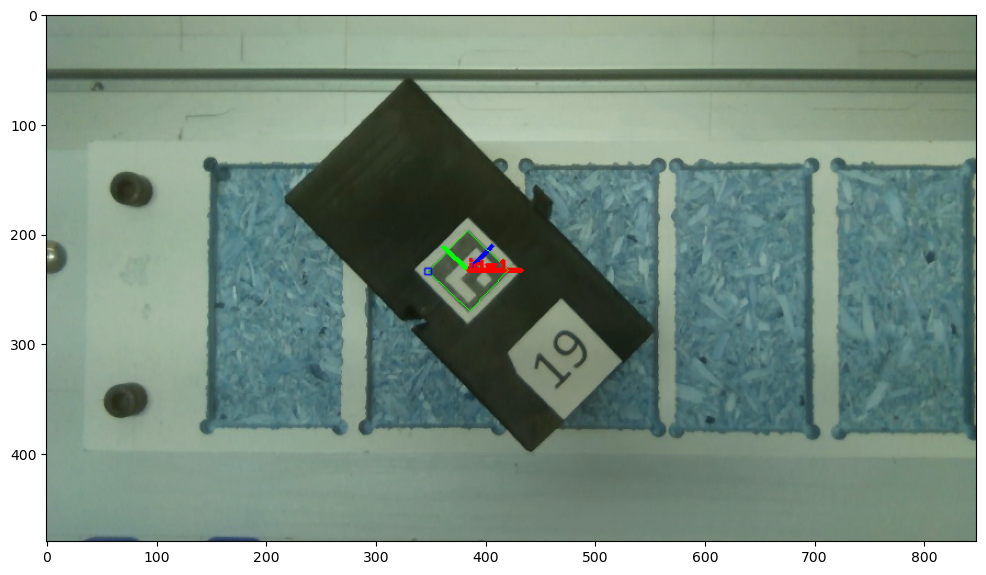

In [1]:
import cv2
import numpy as np
import time
import matplotlib.pyplot as plt
%matplotlib inline
import rtde_control
import rtde_receive
import numpy
import math
rtde_r = rtde_receive.RTDEReceiveInterface("169.254.37.182")
rtde_c = rtde_control.RTDEControlInterface("169.254.37.182")

#Gripper
ip = "169.254.37.182"
import robotiq_gripper
def log_info(gripper):
    print(f"Pos: {str(gripper.get_current_position()): >3}  "
          f"Open: {gripper.is_open(): <2}  "
          f"Closed: {gripper.is_closed(): <2}  ")
print("Creating gripper...")
gripper = robotiq_gripper.RobotiqGripper()
print("Connecting to gripper...")
gripper.connect(ip, 63352)
print("Activating gripper...")
#gripper.activate()


#Capturing position
rtde_c.moveL([-0.00772, -0.64201, 0.19098, 0.032, -3.154, -0.017], 0.5, 0.3)
time.sleep(1)


# Intrensic Matrix Obtained from Camera Calibration
n_mtx = [[5.23058487e+04,0.00000000e+00,4.61024155e+02],[0.00000000e+00,2.81347874e+04,2.39792318e+02],[0.00000000e+00,0.00000000e+00,1.00000000e+00]]
mtx = np.array(n_mtx)
# Distortion Matrix Obtained from Camera Calibration 
n_dist = [5.41119138e+01,-1.12643444e+04,3.13452550e-02,-3.04059948e-01,-4.39888679e+01]
dist = np.array(n_dist)


### CAPTURING FRAME BY USING DISPLAY FUNCTION
def display(img):
    fig=plt.figure(figsize=(12,10))
    ax=fig.add_subplot(111)
    ax.imshow(img)
# Define dictionary for marker detection
aruco_dict = cv2.aruco.Dictionary_get(cv2.aruco.DICT_4X4_100)
# Define parameters for marker detection
parameters = cv2.aruco.DetectorParameters_create()
# Create video capture object
cap = cv2.VideoCapture(0)
cap.set(cv2.CAP_PROP_FRAME_WIDTH, 848)
cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 480)
cap.set(5,30)
t1=time.time()
while True:
    # Read frame from camera
    ret, frame = cap.read()
    t2=time.time()
    if (t2-t1>=1):
        break
# Save frame as image file
cap.release()
cv2.imwrite('aruco.jpg',frame)


# Reading the captured Image
img = cv2.imread("C:/Users/Prajwal/Python Projects/Weimar SRA/TRIALS 1/Random Pose1/aruco.jpg")
# Convert frame to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

### DETECTING THE MARKERS IN THE FRAME
corners, ids, rejectedImgPoints = cv2.aruco.detectMarkers(gray, aruco_dict, parameters=parameters)
print(corners)
if ids is not None:
    # Estimate pose of each marker
    rvec, tvec, _ = cv2.aruco.estimatePoseSingleMarkers(corners, 0.05, mtx, dist)
    # Draw axes on the frame for each marker
    for i in range(ids.size):
        result_img = cv2.drawFrameAxes(img, mtx, dist, rvec[i, :, :], tvec[i, :, :], 0.03)
        # Store the pixel coordinates of the corners for each detected marker
    # Draw marker borders and IDs on the frame
    cv2.aruco.drawDetectedMarkers(img, corners, ids)
# Display the frame
display(img)


### FINDING THE CENTROID OF THE ARUCO/COMPONENT
idx = (corners[0][0][0][0]+corners[0][0][1][0]+corners[0][0][2][0]+corners[0][0][3][0])/4
idy = (corners[0][0][0][1]+corners[0][0][1][1]+corners[0][0][2][1]+corners[0][0][3][1])/4
id = idx,idy
print(id)
#print(id[0])


### ROTATION MATRIX MULTIPLICATION 
# Inverse of Reference Rotation matrix
ref_mat_inv= [[5.37918941e-01,-8.73345818e-04,-8.42996115e-01],[-1.97692365e-02,-9.99737517e-01,-1.15790927e-02],[-8.42764730e-01,2.28940029e-02,-5.37795011e-01]]

# Rotation vector obtained from ArUco marker
rot_vec = np.array([rvec[0][0][0],rvec[0][0][1],rvec[0][0][2]])

# Obtain the rotation matrix from the rotation vector
rot_mat, _ = cv2.Rodrigues(rot_vec)
# Ref_rot_mat x Rot_mat_of_comp
result = np.dot(ref_mat_inv, rot_mat)
# Finding the angle of the ARuco wrt camera frame
angle=np.arcsin(result[1][0])
print('angle: ',angle)
print('angle in degrees:',math.degrees(angle))


### ROBOT TCP MOVES TO THE IDX,IDY OF COMPONENT
import pyrealsense2 as rs
import openpyxl
import time
from statistics import mode
import re

# Parameters
velocity = 0.5
acceleration = 0.5
dt = 1.0/500  # 2ms
lookahead_time = 0.1
gain = 300

result_f={}
depth_dict={}

rtde_c.moveL([-0.00772, -0.64201, 0.15098, 0.032, -3.154, -0.017], 0.5, 0.3)
time.sleep(1)
#Capturing position
rtde_c.moveL([-0.00772, -0.64201, 0.19098, 0.032, -3.154, -0.017], 0.5, 0.3)
time.sleep(1)

def depth_filter(win_data):
    x1,y1,x2,y2=win_data[0]-win_data[2]/2,win_data[1]-win_data[3]/2,win_data[0]+3*win_data[2]/2,win_data[1]+3*win_data[3]/2
    for i in range(int(y1),int(y2)):
        for j in range(int(x1),int(x2)):
            d=aligned_depth_frame.get_distance(int(j),int(i))
            if d!=0:
                k=[j,i]
                depth_dict[f'{k}']=round(d, 2)
    depth_list=depth_dict.values()
    filtered_depth=mode(depth_list)
    print(filtered_depth)
    corr_pix=list(depth_dict.keys())[list(depth_dict.values()).index(filtered_depth)] #get corresponding pixel of the distance value
    print(corr_pix)
    print(type(corr_pix))
    #print(corr_pix) #A string here
    corr_pix=re.split(', ',corr_pix)
    pix_corr=[]
    for num in corr_pix:
        num=re.sub(r"[\([{})\]]", "", num)
        num=int(num)
        pix_corr.append(num)
    
    print(pix_corr)
    print(type(pix_corr))
    a,b=pix_corr[0],pix_corr[1]
    depth=aligned_depth_frame.get_distance(int(a),int(b))
    return depth
def distance(x,y):
    #cv2.circle(capture,(x,y),2,(128,0,128),-1)
    #print((x,y))
    d=depth_frame.get_distance(int(x),int(y))
    print(d)
    if (d==0.0) :
        print('No depth info, Using an window')
        depth=depth_filter([int(x),int(y),10,10])
        x_w, y_w, z_w = convert_depth_to_phys_coord_using_realsense(int(x),int(y), depth, camera_info)
        print('Camera Points are:',x_w, y_w, z_w)
        p1=f'{x_w} {y_w} {z_w}'
        p = [float(value) for value in p1.split(' ')]
        p.append(1.0)
        dst_p=np.matmul(k,p)
        dst_p=dst_p.tolist()
        print(dst_p)
        rtde_c.moveL([dst_p[0]/1000.0, dst_p[1]/1000.0, dst_p[2]/1000.0, 0.032, -3.154, -0.017], 0.5, 0.3)
        #time.sleep(5)
        #dst_p=(dst_p[0])[:-1]
        #print(dst_p)
        del p1
        del p
    else:
        x_w, y_w, z_w = convert_depth_to_phys_coord_using_realsense(int(x),int(y), d, camera_info)
        print('Camera Points are:',x_w, y_w, z_w)
        p1=f'{x_w} {y_w} {z_w}'
        p = [float(value) for value in p1.split(' ')]
        p.append(1.0)
        dst_p=np.matmul(k,p)
        dst_p=dst_p.tolist()
        print(dst_p)
        rtde_c.moveL([dst_p[0]/1000.0, dst_p[1]/1000.0, dst_p[2]/1000.0, 0.032, -3.154, -0.017], 0.5, 0.3)
        #time.sleep(5)
        #dst_p=(dst_p[0])[:-1]
        #print(dst_p)
        del p1
        del p

def convert_depth_to_phys_coord_using_realsense(x, y, depth, cameraInfo):
    _intrinsics = rs.intrinsics()
    _intrinsics.width = cameraInfo.width
    _intrinsics.height = cameraInfo.height
    _intrinsics.ppx = cameraInfo.ppx
    _intrinsics.ppy = cameraInfo.ppy
    _intrinsics.fx = cameraInfo.fx
    _intrinsics.fy = cameraInfo.fy
    # _intrinsics.model = cameraInfo.distortion_model
    _intrinsics.model  = rs.distortion.none
    _intrinsics.coeffs = [i for i in cameraInfo.coeffs]
    result = rs.rs2_deproject_pixel_to_point(_intrinsics, [x, y], depth)
    # result[0]: right, result[1]: down, result[2]: forward
    return result[0], -result[1], -result[2]
"""
# Setup the pipeline
pipe = rs.pipeline()
cfg = rs.config()
cfg.enable_stream(rs.stream.depth, 1280, 720, rs.format.z16, 30)
cfg.enable_stream(rs.stream.color, 1280, 720, rs.format.bgr8, 30)
profile = pipe.start(cfg)
"""

#k= [[-9.99766881e+02,-4.32726613e+00,-3.49871451e+02,-2.08832869e+02],[1.48501389e+01,-1.00379407e+03,-2.10069591e+03,-1.31522522e+03],[-2.18229221e-01,-2.99400687e-01,-8.44418623e+01,4.61947710e+01],[0.00000000e+00,0.00000000e+00,0.00000000e+00,1.00000000e+00]]

k= [[-9.79365051e+02,6.22173726e-01,-1.81205747e+02,-1.09894855e+01],[2.63002626e+00,-9.88050938e+02,-2.41157019e+01,-6.93151121e+02],[1.52250424e+02,7.62100894e+01,-4.30734272e+02,4.48864321e+01],[0.00000000e+00,0.00000000e+00,0.00000000e+00,1.00000000e+00]]

# Create a pipeline
pipeline = rs.pipeline()

# Create a config and configure the pipeline to stream
config = rs.config()
pipeline_wrapper = rs.pipeline_wrapper(pipeline)
pipeline_profile = config.resolve(pipeline_wrapper)
device = pipeline_profile.get_device()
device_product_line = str(device.get_info(rs.camera_info.product_line))
print(device_product_line)
found_rgb = False
for s in device.sensors:
    if s.get_info(rs.camera_info.name) == 'RGB Camera':
        found_rgb = True
        print("There is a depth camera with color sensor")
        break
if not found_rgb:
    print("The demo requires Depth camera with Color sensor")
    exit(0)
config.enable_stream(rs.stream.depth, 848,480, rs.format.z16, 30)
config.enable_stream(rs.stream.color, 848,480, rs.format.bgr8, 30)
profile = pipeline.start(config)


# Setup the 'High Accuracy'-mode
depth_sensor = profile.get_device().first_depth_sensor()
depth_scale = depth_sensor.get_depth_scale()
print("Depth Scale is: " , depth_scale)
clipping_distance_in_meters = 1 #1 meter
clipping_distance = clipping_distance_in_meters / depth_scale
print(clipping_distance)
preset_range = depth_sensor.get_option_range(rs.option.visual_preset)
for i in range(int(preset_range.max)):
    visulpreset = depth_sensor.get_option_value_description(rs.option.visual_preset,i)
    print('%02d: %s'%(i,visulpreset))
    if visulpreset == "High Accuracy":
        depth_sensor.set_option(rs.option.visual_preset, i)
# enable higher laser-power for better detection
depth_sensor.set_option(rs.option.laser_power, 180)
# lower the depth unit for better accuracy and shorter distance covered
depth_sensor.set_option(rs.option.depth_units, 0.0005)
align_to = rs.stream.color
align = rs.align(align_to)
# Skip first frames for auto-exposure to adjust
for x in range(5):
    pipeline.wait_for_frames()
t1=time.time()
try:
    while True:
        # Stores next frameset
        frames = pipeline.wait_for_frames()
        color_frame = frames.get_color_frame()
        depth_frame = frames.get_depth_frame()

        if color_frame:
            aligned_frames = align.process(frames)

            # Get aligned frames
            aligned_depth_frame = aligned_frames.get_depth_frame() # aligned_depth_frame is a 640x480 depth image
            color_frame = aligned_frames.get_color_frame()

            # Validate that both frames are valid
            if not aligned_depth_frame or not color_frame:
                continue

            depth_image = np.asanyarray(aligned_depth_frame.get_data())
            color_image = np.asanyarray(color_frame.get_data())

            # Remove background - Set pixels further than clipping_distance to grey
            black_color = 0
            depth_image_3d = np.dstack((depth_image,depth_image,depth_image)) #depth image is 1 channel, color is 3 channels
            bg_removed = np.where((depth_image_3d > clipping_distance) | (depth_image_3d <= 0), black_color, color_image)

            # Render images:
            #   depth align to color on left
            #   depth on right
            #depth_colormap = cv2.applyColorMap(cv2.convertScaleAbs(depth_image, alpha=0.03), cv2.COLORMAP_JET)
            #images = np.hstack((bg_removed, depth_colormap))
            camera_info = aligned_depth_frame.profile.as_video_stream_profile().intrinsics
            t2=time.time()
            if (t2-t1)>3:
                cv2.imwrite('captured.jpg',bg_removed)
                # cv2.imshow('captured',bg_removed)
                # cv2.waitKey(0)
                # # cv2.destroyAllWindows()
                break
                
finally:
    idi = idx,idy
    time.sleep(1)
    
    for j in range(2):
        distance(idx,idy)
        time.sleep(1)
        #Rotate about Z
        # Move to initial joint position with a regular moveJ
        # actual_q = rtde_r.getActualQ()
        # actual_q[5]-=1.57
        # rtde_c.moveJ(actual_q)
        # time.sleep(1)
        ### Move downwards in Z axis
        ### grip close to 80%
        ### lifts the part in Z axis
        ### Call the destination dictionary
        ### grippen open 
        ### move in Z axis
    
    # # Stop streaming
    # rtde_c.disconnect()
    # pipeline.stop()
    
    

### ROTATING TCP AS PER THE ANGLE OBTAINED
q=rtde_r.getActualQ()
angle=angle - math.radians(90)
q[5]-= angle
rtde_c.moveJ(q, 0.5, 0.3)

### MOVING DOWN IN Z-AXIS TO PICK THE COMPONENT
actual_p=rtde_r.getActualTCPPose()
z_pos=actual_p[2]
actual_p[2]=0.020
rtde_c.moveL(actual_p)
### grip close to 80%
gripper.move_and_wait_for_pos(224, 255, 255)
### lifts the part in Z axis
actual_p=rtde_r.getActualTCPPose()
actual_p[2]=z_pos
rtde_c.moveL(actual_p)
# ### Call the destination dictionary


rtde_r.disconnect()
rtde_c.disconnect()